/var/folders/fq/txj212zs79b9zfmsgd_pc3d40000gn/T/ipykernel_74236/902880252.py:210: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[column].fillna(df[column].mean(), inplace=True)


Epoch [10/10], Loss: 88.3489
Mean Squared Error: 59.18729680337156


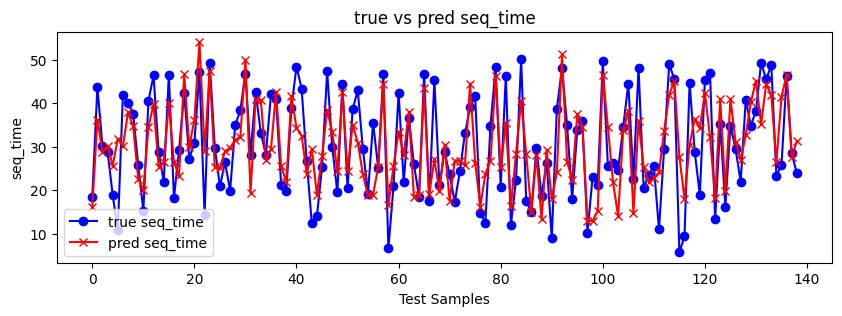

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import os
import numpy as np
import ast
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
import torch
import torch.nn as nn
import torch.optim as optim


######## AE #######
class EncoderDecoder(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(EncoderDecoder, self).__init__()
        self.encoder = nn.Sequential(nn.Linear(input_size, hidden_size), nn.ReLU())
        self.decoder = nn.Sequential(nn.Linear(hidden_size, output_size))

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


# 封装的回归器
class EncoderDecoderRegressor:
    def __init__(self, input_size, hidden_size, output_size, epochs=100, lr=0.001, batch_size=1):
        self.model = EncoderDecoder(input_size, hidden_size, output_size)
        self.epochs = epochs
        self.lr = lr
        self.batch_size = batch_size
        self.criterion = nn.MSELoss()  # 损失函数为均方误差
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.lr)
        self.scaler = MinMaxScaler()

    def fit(self, X_train, y_train):
        # 确保 X_train 和 y_train 都是 numpy 数组
        if isinstance(X_train, np.ndarray) is False:
            X_train = X_train.to_numpy()
        if isinstance(y_train, np.ndarray) is False:
            y_train = y_train.to_numpy()

        # 转换为张量
        X_train = torch.tensor(X_train, dtype=torch.float32)
        y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)  # 如果是回归任务，确保 y_train 是列向量

        # 训练模型
        self.model.train()
        for epoch in range(self.epochs):
            epoch_loss = 0.0
            for i in range(0, len(X_train), self.batch_size):
                X_batch = X_train[i : i + self.batch_size]
                y_batch = y_train[i : i + self.batch_size]
                outputs = self.model(X_batch)
                loss = self.criterion(outputs, y_batch)

                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

                epoch_loss += loss.item()

            if (epoch + 1) % 10 == 0:
                print(f"Epoch [{epoch+1}/{self.epochs}], Loss: {epoch_loss / len(X_train):.4f}")

    def predict(self, X_test):
        if isinstance(X_test, np.ndarray) is False:
            X_test = X_test.to_numpy()

        X_test = torch.tensor(X_test, dtype=torch.float32)

        self.model.eval()
        with torch.no_grad():
            y_pred = self.model(X_test).numpy()
        return y_pred.flatten()


################################


######## VAE #########
# VAE的编码器部分
class VAEEncoder(nn.Module):
    def __init__(self, input_size, hidden_size, latent_size):
        super(VAEEncoder, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc_mu = nn.Linear(hidden_size, latent_size)  # 用于预测均值
        self.fc_logvar = nn.Linear(hidden_size, latent_size)  # 用于预测方差的对数

    def forward(self, x):
        h = self.relu(self.fc1(x))
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar


# VAE 解码器
class VAEDecoder(nn.Module):
    def __init__(self, latent_size, hidden_size, output_size):
        super(VAEDecoder, self).__init__()
        self.fc1 = nn.Linear(latent_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, z):
        h = self.relu(self.fc1(z))
        return self.fc2(h)


# 变分自编码器
class VAE(nn.Module):
    def __init__(self, input_size, hidden_size, latent_size, output_size):
        super(VAE, self).__init__()
        self.encoder = VAEEncoder(input_size, hidden_size, latent_size)
        self.decoder = VAEDecoder(latent_size, hidden_size, output_size)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        return self.decoder(z), mu, logvar


# VAE 回归器，用于训练和预测
class VAERegressor:
    def __init__(self, input_size, hidden_size, latent_size, output_size, epochs=100, lr=0.001, batch_size=1):
        self.model = VAE(input_size, hidden_size, latent_size, output_size)
        self.epochs = epochs
        self.lr = lr
        self.batch_size = batch_size
        self.criterion = nn.MSELoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.lr)
        self.scaler = MinMaxScaler()

    def fit(self, X_train, y_train):
        # 确保 X_train 和 y_train 都是 numpy 数组
        if isinstance(X_train, np.ndarray) is False:
            X_train = X_train.to_numpy()
        if isinstance(y_train, np.ndarray) is False:
            y_train = y_train.to_numpy()

        # 转换为张量
        X_train = torch.tensor(X_train, dtype=torch.float32)
        y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)  # 如果是回归任务，确保 y_train 是列向量

        # 训练模型
        self.model.train()
        for epoch in range(self.epochs):
            epoch_loss = 0.0
            for i in range(0, len(X_train), self.batch_size):
                X_batch = X_train[i : i + self.batch_size]
                y_batch = y_train[i : i + self.batch_size]
                outputs, mu, logvar = self.model(X_batch)
                loss = self.loss_function(outputs, y_batch, mu, logvar)
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                epoch_loss += loss.item()

            # 打印每个 epoch 的损失
            if (epoch + 1) % 10 == 0:
                print(f"Epoch [{epoch + 1}/{self.epochs}], Loss: {epoch_loss / len(X_train):.4f}")

    def loss_function(self, recon_x, x, mu, logvar):
        BCE = self.criterion(recon_x, x)
        # 计算 KL 散度
        KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        return BCE + KLD

    def predict(self, X_test):
        # 确保 X_test 是 numpy 数组
        if isinstance(X_test, np.ndarray) is False:
            X_test = X_test.to_numpy()

        X_test = torch.tensor(X_test, dtype=torch.float32)
        self.model.eval()
        with torch.no_grad():
            y_pred, mu, logvar = self.model(X_test)
        return y_pred.numpy().flatten()


################################


def fill_missing_values(df):
    # 将所有空值转换为 None
    df = df.where(pd.notnull(df), None)
    # 填充空值
    for column in df.columns:
        if df[column].isnull().all():
            # 如果整列都是空值，填充为 0
            df[column].fillna(0, inplace=True)
        elif df[column].dtype == "object":
            # 对于对象类型列，用众数填充
            df[column].fillna(df[column].mode()[0], inplace=True)
        elif pd.api.types.is_numeric_dtype(df[column]):
            # 对于数值类型列，用均值填充
            df[column].fillna(df[column].mean(), inplace=True)
        else:
            # 其他类型列用前向填充
            df[column].fillna(method="ffill", inplace=True)
    return df


def get_files_by_keywords(directory, keywords):
    # 遍历指定文件夹，根据关键字数组提取文件。
    matched_files = []
    for filename in os.listdir(directory):
        if all(keyword in filename for keyword in keywords):
            matched_files.append(filename)
    return matched_files


def process_array_string(array_string):
    # 去掉最大值、最小值并计算平均值
    # 如果输入是单个值，则直接返回
    if isinstance(array_string, (int, float)):
        return array_string
    # 将字符串转换为列表
    values = ast.literal_eval(array_string)
    # 如果列表长度大于2，去掉最大值和最小值
    if len(values) > 2:
        values.remove(max(values))
        values.remove(min(values))
    mean_value = np.mean(values)
    return mean_value


##### 修改这里 #####
ap_name = "3ap"
project_root = "/Users/daylight/Desktop/macos/1Code/Competition/2024ShuMo"
data_dir = project_root + "/data/B"
training_data_names = get_files_by_keywords(data_dir, ["training", ap_name, "csv"])
training_data_all_path = project_root + f"/data/processed/training_data_{ap_name}.csv"
os.makedirs(os.path.dirname(training_data_all_path), exist_ok=True)
training_data_names = sorted(training_data_names)
#### 读取所有训练数据 #####
training_data_all = pd.DataFrame()
# 初始化一个变量来追踪全局的最大 test_id
current_max_test_id = 0
file_split_id = []  # 记录分隔文件的id位置
for file in training_data_names:
    file_path = os.path.join(data_dir, file)
    df = pd.read_csv(file_path)
    # 获取当前合并DataFrame中的最大test_id，如果为空则设置为0
    if not training_data_all.empty:
        max_test_id = training_data_all["test_id"].max()
    else:
        max_test_id = 0
    # 调整新df的test_id，保证test_id连续递增
    df["test_id"] = df["test_id"] + max_test_id
    # 将当前DataFrame追加到总的training_data_all中
    training_data_all = pd.concat([training_data_all, df], ignore_index=True)
    file_split_id.append(training_data_all["test_id"].max())

columns_class = ["ap_id", "sta_id"]
columns_numerical = ["eirp", "nav"]
columns_basic = ["test_id", "seq_time", "protocol"] + columns_numerical
# protocol_name = ["tcp", "udp"]

### 提取对应的列rssi ###
ap_0_sta_0 = ["ap_from_ap_1_mean_ant_rssi", "ap_from_ap_2_mean_ant_rssi", "sta_to_ap_0_mean_ant_rssi", "sta_to_ap_1_mean_ant_rssi", "sta_to_ap_2_mean_ant_rssi", "sta_from_ap_0_mean_ant_rssi", "sta_from_ap_1_mean_ant_rssi", "sta_from_ap_2_mean_ant_rssi", "sta_from_sta_1_rssi", "sta_from_sta_2_rssi"]
ap_1_sta_1 = ["ap_from_ap_0_mean_ant_rssi", "ap_from_ap_2_mean_ant_rssi", "sta_to_ap_0_mean_ant_rssi", "sta_to_ap_1_mean_ant_rssi", "sta_to_ap_2_mean_ant_rssi", "sta_from_ap_0_mean_ant_rssi", "sta_from_ap_1_mean_ant_rssi", "sta_from_ap_2_mean_ant_rssi", "sta_from_sta_0_rssi", "sta_from_sta_2_rssi"]
ap_2_sta_2 = ["ap_from_ap_0_mean_ant_rssi", "ap_from_ap_1_mean_ant_rssi", "sta_to_ap_0_mean_ant_rssi", "sta_to_ap_1_mean_ant_rssi", "sta_to_ap_2_mean_ant_rssi", "sta_from_ap_0_mean_ant_rssi", "sta_from_ap_1_mean_ant_rssi", "sta_from_ap_2_mean_ant_rssi", "sta_from_sta_0_rssi", "sta_from_sta_1_rssi"]

training_data_all_ap_0 = training_data_all.loc[training_data_all["ap_id"] == "ap_0"].copy()
for i, column in enumerate(ap_0_sta_0):
    training_data_all_ap_0[column] = training_data_all_ap_0[column].apply(process_array_string)

training_data_all_ap_1 = training_data_all.loc[training_data_all["ap_id"] == "ap_1"].copy()
for i, column in enumerate(ap_1_sta_1):
    training_data_all_ap_1[ap_0_sta_0[i]] = training_data_all_ap_1[column].apply(process_array_string)

training_data_all_ap_2 = training_data_all.loc[training_data_all["ap_id"] == "ap_2"].copy()
for i, column in enumerate(ap_2_sta_2):
    training_data_all_ap_2[ap_0_sta_0[i]] = training_data_all_ap_2[column].apply(process_array_string)

training_data_all_processed = pd.concat([training_data_all_ap_0[columns_basic + ap_0_sta_0], training_data_all_ap_1[columns_basic + ap_0_sta_0]], ignore_index=True)
training_data_all_processed = pd.concat([training_data_all_processed, training_data_all_ap_2[columns_basic + ap_0_sta_0]], ignore_index=True)

######## 训练模型 #######
random_state_num = 6103
# 去掉空值
training_data = training_data_all_processed.loc[:, columns_basic + ap_0_sta_0].dropna().copy()
# 编码非数值变量
training_data_encoded = pd.get_dummies(training_data, columns=["protocol"])
training_data_encoded = fill_missing_values(training_data_encoded)

# 拼接向量
X = training_data_encoded[columns_numerical + ap_0_sta_0 + [col for col in training_data_encoded.columns if col.startswith("protocol_")]]
y = training_data_encoded["seq_time"]

# 将数据分为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state_num)

# 归一化特征
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#### 模型训练 ####
# 线性回归
# model = LinearRegression()
# XGBoost
# model = xgb.XGBRegressor(objective="reg:squarederror", random_state=random_state_num)
# 随机森林
# model = RandomForestRegressor(random_state=42)
# 支持向量回归
# model = SVR(kernel='rbf')
# 神经网络回归模型
# model = MLPRegressor(hidden_layer_sizes=(128,64,32), max_iter=1000, alpha=0.001, random_state=42)
# model = EncoderDecoderRegressor(input_size=X_train_scaled.shape[1], hidden_size=64, output_size=1, epochs=1000, lr=0.001, batch_size=1)
model = VAERegressor(input_size=X_train_scaled.shape[1], hidden_size=20, latent_size=5, output_size=1, epochs=10, lr=0.001, batch_size=1)
# 训练模型
model.fit(X_train_scaled, y_train)
# 对测试集进行预测
y_pred = model.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# 对比曲线图：真实值 vs 预测值
plt.figure(figsize=(10, 3))
plt.plot(np.arange(len(y_test)), y_test, label="true seq_time", color="blue", marker="o")
plt.plot(np.arange(len(y_pred)), y_pred, label="pred seq_time", color="red", marker="x")
plt.xlabel("Test Samples")
plt.ylabel("seq_time")
plt.title("true vs pred seq_time")
plt.legend()
plt.show()

#### 只有树模型才有
# 打印每个特征的重要性
# importance = model.feature_importances_
# # 可视化特征重要性
# plt.figure(figsize=(10, 3))
# plt.barh(X_train.columns, importance)
# plt.xlabel("Feature Importance")
# plt.ylabel("Features")
# plt.title("Feature Importance Analysis")
# plt.show()

In [6]:
###### 预测，将训练集也预测用于question2 #######
test_data_names = get_files_by_keywords(data_dir, [ap_name, "csv"])
test_data_names = sorted(test_data_names)
question1_results_dir = project_root + "/data/results/question1"
os.makedirs(question1_results_dir, exist_ok=True)
for test_data_name in test_data_names:
    file_path = os.path.join(data_dir, test_data_name)
    test_data_all = pd.read_csv(file_path)

    test_data_ap_0 = test_data_all.loc[test_data_all["ap_id"] == "ap_0"].copy()
    for i, column in enumerate(ap_0_sta_0):
        test_data_ap_0[column] = test_data_ap_0[column].apply(process_array_string)

    test_data_ap_1 = test_data_all.loc[test_data_all["ap_id"] == "ap_1"].copy()
    for i, column in enumerate(ap_1_sta_1):
        test_data_ap_1[ap_0_sta_0[i]] = test_data_ap_1[column].apply(process_array_string)

    test_data_ap_2 = test_data_all.loc[test_data_all["ap_id"] == "ap_2"].copy()
    for i, column in enumerate(ap_2_sta_2):
        test_data_ap_2[ap_0_sta_0[i]] = test_data_ap_2[column].apply(process_array_string)

    test_data_processed = pd.concat([test_data_ap_0[columns_basic + ap_0_sta_0], test_data_ap_1[columns_basic + ap_0_sta_0]], ignore_index=True)
    test_data_processed = pd.concat([test_data_processed, test_data_ap_2[columns_basic + ap_0_sta_0]], ignore_index=True)

    ####### 预测数据 ########
    test_data = test_data_processed.loc[:, columns_basic + ap_0_sta_0].copy()
    # 编码非数值变量
    test_data_encoded = pd.get_dummies(test_data, columns=["protocol"])
    X_test_data = test_data_encoded[columns_numerical + ap_0_sta_0 + [col for col in test_data_encoded.columns if col.startswith("protocol_")]]
    
    X_test_data = fill_missing_values(X_test_data)

    # 对测试数据进行归一化（使用与训练集相同的 scaler）
    X_test_final_scaled = scaler.transform(X_test_data)
    # 使用训练好的模型进行预测
    y_test_pred = model.predict(X_test_final_scaled)
    # 输出预测结果
    test_data_all["predict seq_time"] = y_test_pred
    test_data_all.to_csv(f"{question1_results_dir}/{test_data_name}", index=False)
    # test_data["predict seq_time"] = y_test_pred

    # plt.figure(figsize=(10, 3))
    # plt.plot(np.arange(len(test_data["predict seq_time"])), test_data["predict seq_time"], label="predict seq_time")
    # plt.plot(np.arange(len(test_data["ap_from_ap_1_mean_ant_rssi"])), test_data["ap_from_ap_1_mean_ant_rssi"], label="ap_from_ap_1_mean_ant_rssi")
    # plt.legend()
    # plt.show()

/var/folders/fq/txj212zs79b9zfmsgd_pc3d40000gn/T/ipykernel_74236/2200053105.py:26: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[column].fillna(df[column].mean(), inplace=True)
/var/folders/fq/txj212zs79b9zfmsgd_pc3d40000gn/T/ipykernel_74236/2200053105.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column].fillna(df[column].mean(),